In [1]:
!pip install --upgrade gdown

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
!pip install torchvision==0.12

     |████████████████████████████████| 21.0 MB 84.1 MB/s 
     |████████████████████████████████| 750.6 MB 11 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch-1.10.0+cu111
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.11.1+cu111
    Uninstalling torchvision-0.11.1+cu111:
      Successfully uninstalled torchvision-0.11.1+cu111
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.11.0 requires torch==1.10.0, but you have torch 1.11.0 which is incompatible.
torchaudio 0.10.0+cu111 requires torch==1.10.0, but you have torch 1.11.0 which is incompatible.


In [2]:
import torch
import torchvision
from torchvision.transforms import ToTensor
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch.nn as nn

In [3]:
# making a directory where the data file will be moved
!mkdir '/content/root'
!mkdir '/content/root/pcam'

mkdir: cannot create directory ‘/content/root’: File exists
mkdir: cannot create directory ‘/content/root/pcam’: File exists


In [4]:
# data file is moved from drive to local directory
!cp '/content/drive/MyDrive/PRML_Project/Dataset/camelyonpatch_level_2_split_test_x.h5' '/content/root/pcam/'
!cp '/content/drive/MyDrive/PRML_Project/Dataset/camelyonpatch_level_2_split_test_y.h5' '/content/root/pcam/'
!cp '/content/drive/MyDrive/PRML_Project/Dataset/camelyonpatch_level_2_split_train_x.h5' '/content/root/pcam/'
!cp '/content/drive/MyDrive/PRML_Project/Dataset/camelyonpatch_level_2_split_train_y.h5' '/content/root/pcam/'
!cp '/content/drive/MyDrive/PRML_Project/Dataset/camelyonpatch_level_2_split_valid_x.h5' '/content/root/pcam/'
!cp '/content/drive/MyDrive/PRML_Project/Dataset/camelyonpatch_level_2_split_valid_y.h5' '/content/root/pcam/'

In [5]:
# Dataset is created from the folder data
train_dataset = torchvision.datasets.PCAM('/content/root/',"train",transform=ToTensor())
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32,shuffle=False, num_workers=2)

val_dataset = torchvision.datasets.PCAM('/content/root/',"val",transform=ToTensor())
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32,shuffle=False, num_workers=2)

test_dataset = torchvision.datasets.PCAM('/content/root/',"test",transform=ToTensor())
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32,shuffle=False, num_workers=2)


In [6]:
train_iter = iter(train_loader)
np.array(train_iter.next())[0].shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


torch.Size([32, 3, 96, 96])

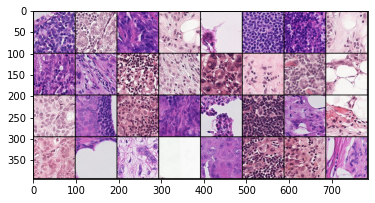

In [7]:
# Plotting some random images for better visualization
def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

## get some random images
dataiter = iter(train_loader)
images, labels = dataiter.next()

## show images
imshow(torchvision.utils.make_grid(images))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2318.)
  from ipykernel import kernelapp as app


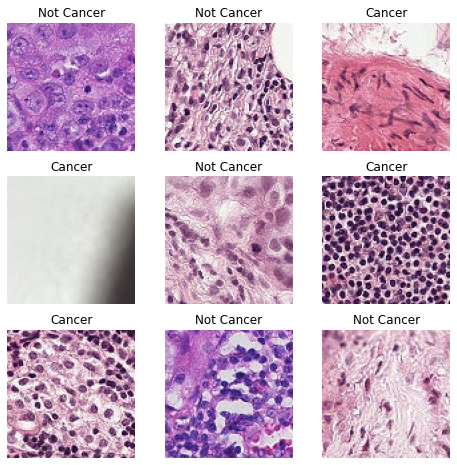

In [8]:
## Some images belonging to different classes
import matplotlib.pyplot as plt
labels_map = {
    0: "Cancer",
    1: "Not Cancer"
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze().T, cmap="gray")
plt.show()

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### MLP


In [10]:
class MLP(nn.Module):
    def __init__(self,input_size,hidden1_size,hidden2_size,output_size):
        super(MLP,self).__init__()
        self.linear1 = nn.Linear(input_size,hidden1_size)
        self.activation1 = nn.ReLU()
        self.linear2 = nn.Linear(hidden1_size,hidden2_size)
        self.activation2 = nn.ReLU()
        self.linear3 = nn.Linear(hidden2_size,output_size)
    def forward(self,data):
        out = self.linear1(data)
        out = self.activation1(out)
        out = self.linear2(out)
        out = self.activation2(out)
        out = self.linear3(out)
        return out

In [15]:
batch_size = 8
num_epochs = 4
lr = 0.001
input_size = 27648
hidden1_size = 27648//8
hidden2_size = hidden1_size//16
output_size = 2
model = MLP(input_size,hidden1_size,hidden2_size,output_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),lr = lr)

In [16]:
from tqdm.notebook import tqdm_notebook as tqdm

In [13]:
!pip install wandb
import wandb
wandb.require("service")

     |████████████████████████████████| 1.8 MB 5.4 MB/s 
     |████████████████████████████████| 144 kB 44.2 MB/s 
     |████████████████████████████████| 181 kB 63.3 MB/s 
     |████████████████████████████████| 63 kB 2.0 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=5cb03e942c325403e25f22a10318f705af5024ac713af14d527af225bc2d8489
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools


In [ ]:
for epoch in tqdm(range(num_epochs)):
    for idx, (images,labels) in enumerate(train_loader):
        images = images.view(32,-1).to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs,labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    with torch.no_grad():
        n_correct = 0
        n_samples = 0
        fn = 0
        for idx, content in enumerate(val_loader):
            optimizer.zero_grad()
            images = images.view(32,-1).to(device)
            labels = labels.to(device)
            outputs = model(images)
            # max returns (value ,index)
            _, predicted = torch.max(outputs.data, 1)
            n_samples += labels.size(0)
            n_correct += (predicted == labels).sum().item()
            fn += ((predicted+1)==labels).sum().item()
        acc = 100.0 * n_correct / n_samples
        fnr = 100.0 * fn/(fn+n_correct)
        print(f'Validation accuracy: {acc} %, fnr : {fnr}')

  0%|          | 0/4 [00:00<?, ?it/s]

Validation accuracy: 75.0 %, fnr : 20.0


In [ ]:
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for images, labels in test_loader:
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        outputs = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs.data, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network on the 10000 test images: {acc} %')